# Person - forecasting

The purpose here is to generate the most accurate hourly forecast given a set of data points with collected and engineered features.

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

### Load dataset

In [2]:
filename = '../Datasets/Person_features__2019-09-09_2020-03-02.pickle'
infile = open(filename,'rb')
(numerical, dummies, cyclical, raw_data), y = pickle.load(infile)
infile.close()

### Comment on data volume

The data covers 6 months of collected images and we have 4140 hourly object counts for analysis.

Unfortunately to see the full seasonality on the dataset, it would be beneficial to have a full year (or ideally even 2 years) of data, which would increase the likelyhood of producing more accurate forecast.

Especially when Neural Networks were used, I have observed that they very quickly overfit the data, and therefore a very simple architecture and additional layers to prevent overfitting were used.

### Verify targets

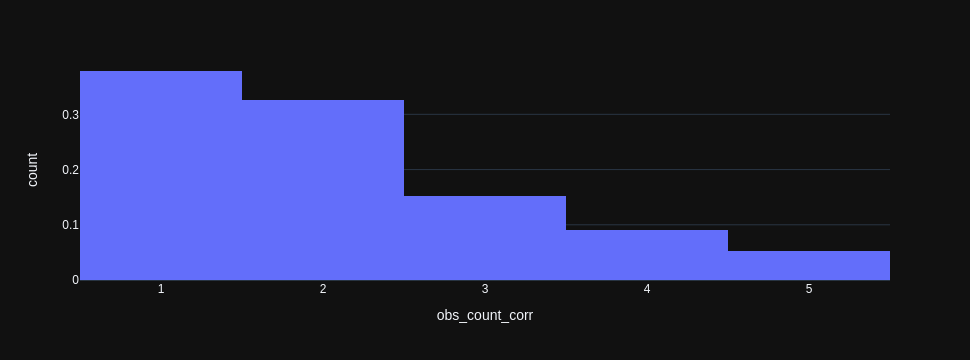

In [3]:
idx = raw_data['obs_count_corr'] > 0
px.histogram(raw_data[idx], x="obs_count_corr", height=300, width=600, nbins=8,
             histnorm='probability density')

### Filter out nightly hours dilemma

For now I am making a decision to include the night-time hours.

But this can be changed based on the following fact: Current data collection and specifically lack of a night vision camera drives all nightly observations to pretty much 0.

If we wanted to, we could use the daily sunrise and sunset time to exclude only relevant data points, instead of blindly removing too much data. This code snippet could do this for us:

```python
# convert timestamps to hours
conv_ts = lambda x: datetime.fromtimestamp(x).hour
df['sunrise_hour'] = df['daily__sunriseTime'].apply(conv_ts)
df['sunset_hour'] = df['daily__sunsetTime'].apply(conv_ts)

# remove nightly records
idx = (df['hour'] < df['sunrise_hour']) | (df['hour'] > df['sunset_hour'])
df = df.loc[~idx]
```

It might be a good idea to revisit this when deciding on the final model to use

### Error analysis plot/outputs

In [459]:
error_tracker = {}
def analyse_error(y_test, y_pred, model_name, show_plot=True):    
    df = pd.DataFrame()
    df['obs_count_corr'] = y_test
    df['predicted'] = y_pred
    df['abs_error'] = (df['obs_count_corr'] - df['predicted']).abs()
    total_abs_error = df['abs_error'].sum()  ##
    idx = df['abs_error'] == 0
    total_corr_samples = df[idx].shape[0]  ##
    total_samples = df.shape[0]  ##
    acc = round(df[idx].shape[0] / df.shape[0], 2)  ##
    idx_total = (df['obs_count_corr'] > 0)
    idx_total_correct = (df['obs_count_corr'] > 0) & (df['abs_error'] == 0)
    acc_not_zero_count = round(df[idx_total_correct].shape[0] / df[idx_total].shape[0], 2)  ##
    idx = df['abs_error'] > 0
    error_tracker[model_name] = {
        'total_samples': total_samples,
        'total_abs_error': total_abs_error,
        'total_corr_samples': total_corr_samples,
        'acc': acc,
        'acc_not_zero_count': acc_not_zero_count
    }
    if show_plot:
        fig = px.histogram(df[idx], x="abs_error", opacity=0.7, height=325, width=800,
                           nbins=8, title=f'Absolute error distribution for {model_name} Model')
        fig.show()
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=y_test.tolist()[:150], mode='lines', name='True', opacity=0.7))
        fig.add_trace(go.Scatter(y=y_pred.tolist()[:150], mode='lines', name='Predicted', opacity=0.7))
        fig.update_layout(title='True vs Predicted counts', height=375)
        fig.show()

### Baseline simple model (without Machine Learning)

Firstly - create a crude model, which will use hourly averages to generate a forecast.

Even though this model is very simplistic, it is actually quite robust, very fast to execute and easy to explain.

In [460]:
# create a train/test split for the dataset
X = raw_data[['hour', 'obs_count_corr']]
X_train, X_test, y_train, y_test = train_test_split(
    X, raw_data['obs_count_corr'], test_size=0.25, random_state=41)

In [461]:
# calculate hourly averages of counts for training set
mean_obj_counts = X_train.groupby('hour')['obs_count_corr'].mean()

In [462]:
# now we can generate the predictions for the test set
y_pred = X_test['hour'].map(mean_obj_counts)

In [463]:
# round results
y_pred_rounded = np.array([round(p) for p in y_pred])

In [464]:
# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

mse: 1.0415458937198068
mae 0.5893719806763285


Even though the mean squared error is a good metric to utilise in the analytical framework (high errors should be penalised more), it is easier to interpret the mean absolute error in a visual mode.

Absolute error is calculated as: $$error=abs(y\_test-y\_pred)$$

Histogram below shows the magnitute of mistakes made by the model, the lower the count on the y-axis and the more it is clustered to zero on the x-asis, the better the model is.

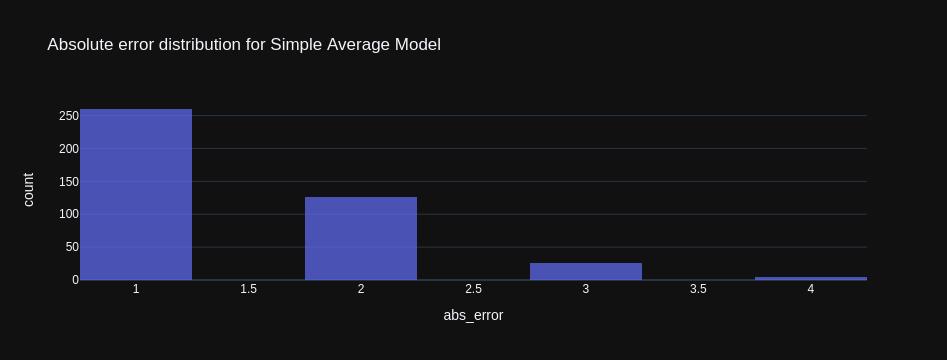

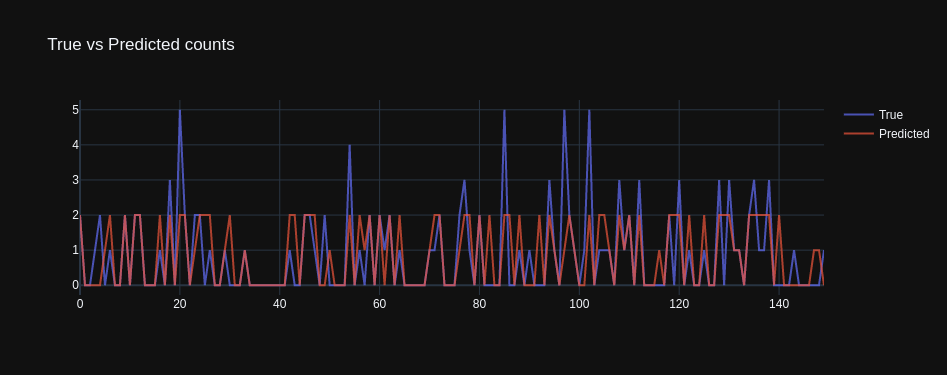

{'total_samples': 1035, 'total_abs_error': 610, 'total_corr_samples': 618, 'acc': 0.6, 'acc_not_zero_count': 0.33}


In [465]:
analyse_error(y_test, y_pred_rounded, 'Simple Average')
print(error_tracker['Simple Average'])

### Prepare X and y

- define X and y
- split into traning and testing
- scale data

In [250]:
# handy utility function to merge multiple dataframes
def merge_datasets(datasets):
    """
    Usages:
    - merge_datasets([numerical, dummies, cyclical])
    - merge_datasets([dummies, cyclical])
    - merge_datasets([numerical, dummies])
    """
    df = datasets[0].copy()
    for d_next in datasets[1:]:
        df = df.merge(d_next, left_index=True, right_index=True)
    return df

In [251]:
# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])

# add-in hour from the raw features
X['hour'] = raw_data['hour']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, raw_data['obs_count_corr'], test_size=0.25, random_state=0)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Machine Learning linear model (Linear Regression)

Can an ML model pick up on linear relationships between features and improve the baseline model?

mse: 1.055072463768116
mae: 0.6241545893719807


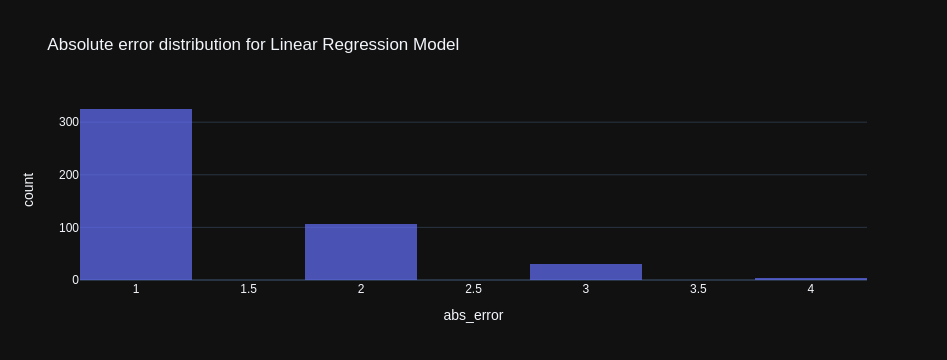

{'total_samples': 1035, 'total_abs_error': 646.0, 'total_corr_samples': 569, 'acc': 0.55, 'acc_not_zero_count': 0.4}


In [252]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = [round(p) for p in y_pred]

# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae:', mean_absolute_error(y_test, y_pred_rounded))

analyse_error(y_test, y_pred_rounded, 'Linear Regression')
print(error_tracker['Linear Regression'])

As can be seen in the statistics above, the linear Machine Learning model is actually much worse than the simple averages model. It's also not powerful enough to exploit any non-linear relationships between features and the output variable.

### Random Forest model

Can an ML model pick up on non-linear relationships between features and improve the baseline model?

In [253]:
from sklearn.ensemble import RandomForestRegressor

In [254]:
# fit model and make predictions
model = RandomForestRegressor(n_estimators=100, criterion='mse')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = np.array([int(round(p)) for p in y_pred])

print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print('true:', y_test[:10].tolist())
print('pred:', y_pred_rounded[:10].tolist())

mse: 0.9207729468599034
mae 0.5516908212560386
true: [0, 0, 0, 0, 2, 1, 2, 0, 1, 1]
pred: [0, 0, 0, 1, 2, 1, 2, 0, 2, 1]


As we can see, based on the output above - Random Forest does an ok enough job at predicting the counts. I have also tested SVM (using SVR class in sklearn) but it did not show any improvement over the Random Forest model.

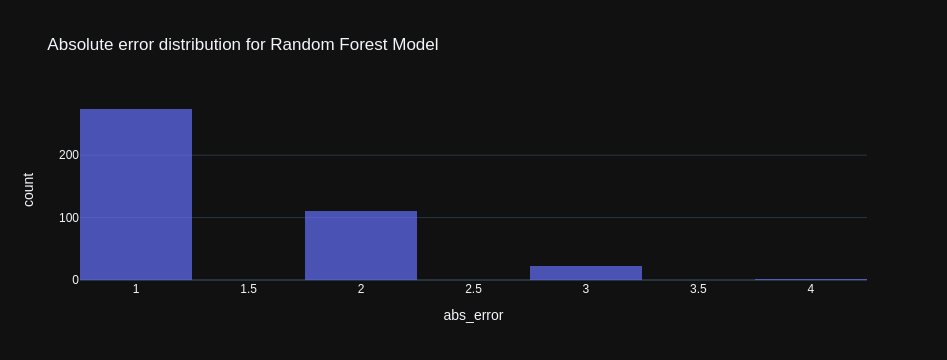

{'total_samples': 1035, 'total_abs_error': 571, 'total_corr_samples': 626, 'acc': 0.6, 'acc_not_zero_count': 0.37}


In [255]:
analyse_error(y_test, y_pred_rounded, 'Random Forest')
print(error_tracker['Random Forest'])

### Test Neural Network approach

I have tested many variations of the Feed Forward Neural Network.

The best performing (and also fitting the purpose) turned out to be a simple Network with only two 6-neuron hidden layers and a Dropout layer of rate 0.1 to a slight prevent overfitting, which was occurring.

Increasing model's complexity results in overfitting, as we only have ~3,100 data points in the training sample. As seen in the model summary below, the model has 199 trainable parameters. According to the best practices in Deep Learning, where we should always have 10x more data samples than parameters in the model - this model is not breaching this rule.

Activation functions have been chosen carefully to fit the purpose:
- hidden layers use **relu** (as a standard in modern neural network hidden layers)
- output layer uses **exponential** (as outputs should not be negative and it's used for modelling count data)

Lowering learning rate resulted in a much more smooth loss curve.

Training the model for 40 epochs with a batch size of 16 was the sweet spot to achieve the best convergence.

The predictions generated by the model had to be rounded to the nearest integer, as we are modelling the count data (which should not be a floating point type).

In [256]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.activations import exponential

In [273]:
# Define layers
inputs = Input(shape=(X.shape[1],))
x = Dense(6, activation="relu")(inputs)
x = Dropout(0.1)(x)
x = Dense(6, activation="relu")(x)
outputs = Dense(1, activation="exponential")(x)
# Create model
model = Model(inputs=inputs, outputs=outputs, name="nn_reg_model")
opt = Adam(learning_rate=0.0013)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
model.summary()

Model: "nn_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 24)]              0         
_________________________________________________________________
dense_58 (Dense)             (None, 6)                 150       
_________________________________________________________________
dropout_26 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


mse: 0.923671497584541
mae 0.5507246376811594


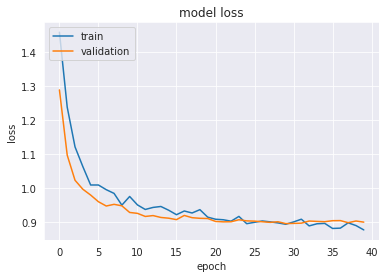

In [274]:
history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=16,
                    verbose=0, validation_data=(X_test_scaled, y_test))
# Predict and calculate stats
y_pred = model.predict(X_test_scaled)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Analysis:
- The validation loss curve is smooth, which indicates a good choice of learning rate
- There is no overfitting visible, as validation loss does not jump upwards
- Model converges after 30-40 epochs by minimising the mean squared error ($mse\approx0.92$)

In [275]:
# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print(y_pred_rounded[:10].tolist())
print(y_test[:10].tolist())

[0, 0, 0, 0, 2, 1, 2, 0, 2, 1]
[0, 0, 0, 0, 2, 1, 2, 0, 1, 1]


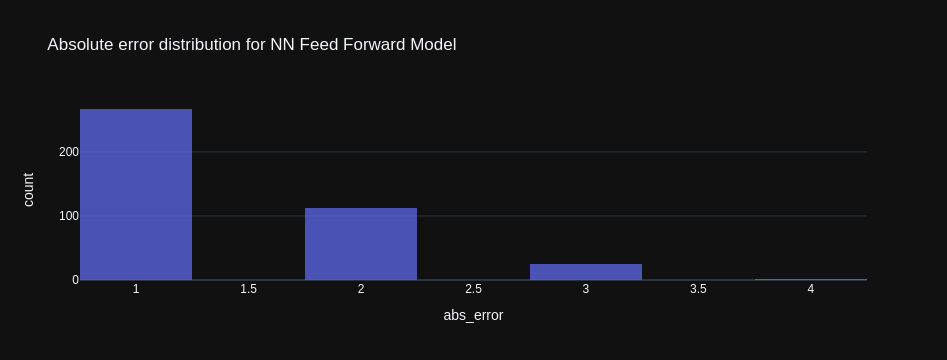

{'total_samples': 1035, 'total_abs_error': 570, 'total_corr_samples': 630, 'acc': 0.61, 'acc_not_zero_count': 0.35}


In [277]:
analyse_error(y_test, y_pred_rounded, 'NN Feed Forward')
print(error_tracker['NN Feed Forward'])

So far, in terms of Neural Networks - the **NN Feed Forward** model has the best error statistics. But the results are almost the same as the **Random Forests** model (only slightly better).

I have also tested a Neural Network with the Poisson family loss function (**Zero inflated Negative Bonomial**), which is used to model a distibution of count data dominated by zeros.

Inspired by an excellent implementation available [here in Colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb#scrollTo=FQFfRlKfLjUi), the results did not show any improvement over the simpler Feed Forward Network (at best they were 20% worse), so I have excluded it from this analysis.

### Multivariate LSTM Recurrent NN

In terms of forecasting and Neural Networks, a golden standard is the LSTM model.

While it did not achieve a significantly better results then the simpler cousin - Feed Forward Neural Net, I am including the experiment due to the interesting and unique preprocessing of the inputs and that the model accuracy was indeed a little bit higher (0.63 vs 0.61 with Feed Forward NN).

First of all, due to the small size of training data, a very simple LSTM architecture was utilised with only 2 LSTM units and a 0.1 Droput layer to prevent serious overfitting. Even this simpe model generated already a 437 weights to keep track of.

How does it all work?

In order to feed a Recurrent Neural net we need to prepare a sequence of data points. Even though I did it manually up front, it turned out that Keras makes it very easy with its `TimeseriesGenerator` class.

What we need to think about is how many records do we include in a sequence, but this can be easily controlled by the `length` parameter. This is something, which is promising, but as of now a number of 4 has produced the most optimal results.

What's very important and also unique is the `shuffle=False` parameter in the call to the `fit` method. The chronological order of records is crucial and critical to RNNs to work.

The results were on par with the Feed Forward Network, but with additional data and time for experiments, it feels like the LSTM approach has a good potential to become the most accurate model (with a tradeoff of being also the slowest and resource-hungy one).

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional

In [357]:
# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])

# add-in hour from the raw features
X['hour'] = raw_data['hour']

# split into training/testing (without the shuffle as order is important here)
X_train, X_test, y_train, y_test = train_test_split(
    X, raw_data['obs_count_corr'], test_size=0.25, shuffle=False)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [364]:
BACKWARD_LAG = 4
BATCH_SIZE = 32
data_gen_train = TimeseriesGenerator(X_train_scaled, y_train.to_numpy(),
                                     length=BACKWARD_LAG, batch_size=BATCH_SIZE)
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(),
                                    length=BACKWARD_LAG, batch_size=BATCH_SIZE)

In [365]:
model = Sequential()
model.add(Bidirectional(
    LSTM(2),
    input_shape=(BACKWARD_LAG, X_train_scaled.shape[1])
))
model.add(Dropout(0.1))
model.add(Dense(1))
opt = Adam(learning_rate=0.0013)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
history = model.fit(data_gen_train, epochs=40, verbose=0, validation_data=data_gen_test, shuffle=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [366]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 4)                 432       
_________________________________________________________________
dropout_39 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 5         
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


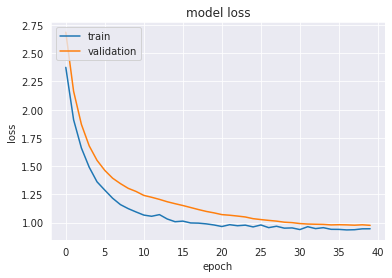

In [367]:
# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [368]:
# prepare test data
BATCH_SIZE = 1
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(), length=BACKWARD_LAG, batch_size=BATCH_SIZE)
X_test_rnn = []
y_test_rnn = []
for X, y in data_gen_test:
    X_test_rnn.append(X)
    y_test_rnn.append(y)
X_test_rnn = np.array(X_test_rnn)
y_test_rnn = np.array(y_test_rnn)
X_test_rnn = np.squeeze(X_test_rnn)  # remove the extra dimension (related to batch)
y_test_rnn = np.array([p[0] for p in y_test_rnn])

In [369]:
# Predict and calculate stats
y_pred = model.predict(X_test_rnn)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test_rnn, y_pred_rounded))
print('mae', mean_absolute_error(y_test_rnn, y_pred_rounded))

mse: 0.9573229873908826
mae 0.5363724539282251


In [370]:
# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print('pred:', y_pred_rounded[:20].tolist())
print('true:', y_test_rnn[:20].tolist())

pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 3, 3]
true: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 4, 0, 4, 2]


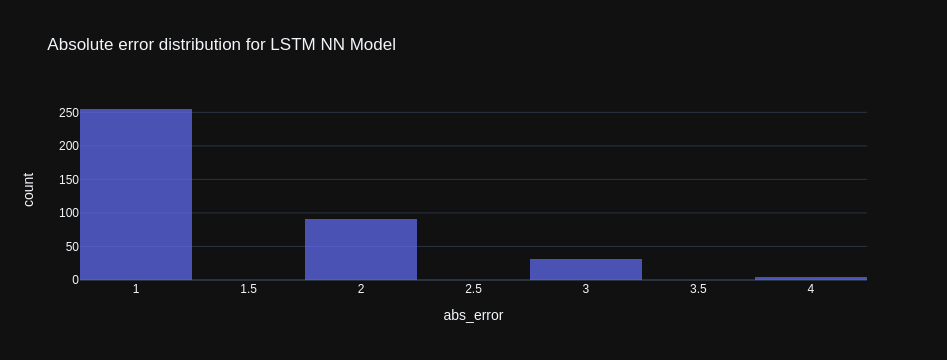

{'total_samples': 1031, 'total_abs_error': 553, 'total_corr_samples': 648, 'acc': 0.63, 'acc_not_zero_count': 0.33}


In [372]:
analyse_error(y_test_rnn, y_pred_rounded, 'LSTM NN')
print(error_tracker['LSTM NN'])

### Overall stats

Below I am displaying error statistics for all the models included in this experiment. I have tested many more models and tweaked hyperparameters of the existing models and I feel that there is still a little room for improvement with more time and patience on hand.

So which model should be chosen here?

It really depends on the requirements. If the total accuracy is the most important, then LSTM is the best. If the accuracy for the non-zero counts is the most important, then Linear Regression wins by quite a bit.

All these differences are actually not great enough to convince me to utilise a Machine Learning model, and I would choose the most simple and explainable model, the **Simple Average model**, which does a good enough job at indicating a number objects to expect at a given time.

In [373]:
error_df = pd.DataFrame(error_tracker).T.sort_values('acc', ascending=False)
error_df

,total_samples,total_abs_error,total_corr_samples,acc,acc_not_zero_count
LSTM NN,1031.0,553.0,648.0,0.63,0.33
NN Feed Forward,1035.0,570.0,630.0,0.61,0.35
Simple Average,1035.0,610.0,618.0,0.60,0.33
Random Forest,1035.0,571.0,626.0,0.60,0.37
Linear Regression,1035.0,646.0,569.0,0.55,0.40
